In [1]:
import scipy
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

In [11]:
class Recording:
    # Data paths
    root = 'C:/Users/annej/OneDrive/Documents/GitHub/MASTER-eeg-stress-det'
    dir_raw = root + '/Data/ICA_data'
    dir_filtered = root + '/Data/ICA_data_2'
    
    # Parameters
    Fs = 250
    ch_type = 'eeg'
    n_channels = 8
    
    def __init__(self, sub_nr, ses_nr, run_nr):
        self.sub_nr = sub_nr
        self.ses_nr = ses_nr
        self.run_nr = run_nr
        
        # Load data
        self.load_data()
                
        # Create mne RawArray
        info = mne.create_info(8, sfreq=self.Fs, ch_types=self.ch_type, verbose=None)
        self.raw_arr = mne.io.RawArray(self.data*1e-6, info)
        
        mapping = {'0':'F4','1':'Fp2','2':'C3','3':'FC6','4':'O1','5':'Oz','6':'FT9','7':'T8'}
        mne.rename_channels(self.raw_arr.info, mapping)
        
        # Set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        self.raw_arr.set_montage(montage)   
    #----------------------------------------------------------------------------------------------------
    
    def load_data(self):
        dir = self.dir_raw
        data_key = 'Clean_data'
        # Load one recording
        filename = f"/sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}.mat"
        f = dir + filename
        self.data = scipy.io.loadmat(f)[data_key]

    def save_data(self):
        title = f"sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
        clean_data = self.reconst_arr.to_data_frame(scalings=1e6)
        clean_data = clean_data.to_numpy()
        clean_data = np.transpose(clean_data)
        clean_dict = {
            "Clean_data" : clean_data[1:, :]  #First column of dataFrames is not data
        }
        scipy.io.savemat(f'{self.root}/Data/ICA_data/{title}.mat', clean_dict)
    
    def init_ICA(self):
        self.ica = mne.preprocessing.ICA(n_components=8, max_iter=10000, random_state=97)
        self.ica.fit(self.raw_arr)
        
    def plot_sources(self):
        self.ica.plot_sources(self.raw_arr, title=f'ICA components sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}', show_scrollbars=False)
        self.ica.plot_components(colorbar=True, reject='auto')
        
    def plot_properties(self, components):
        self.ica.plot_properties(self.raw_arr, picks = components)
        
    def test_exclude(self, components):
        self.ica.plot_overlay(self.raw_arr, exclude=components, picks='eeg', stop = 300.)

    def exclude_ICA(self, components):
        self.ica.exclude = components
        self.reconst_arr = self.raw_arr.copy()
        self.ica.apply(self.reconst_arr)
    
    def plot(self, data_type, save=False):
        if data_type == 'ica' and save == True:
            with mne.viz.use_browser_backend('matplotlib'):
                title = f"ICA components sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                fig = self.ica.plot_sources(self.raw_arr, title=title, 
                                            show_scrollbars=False)
                fig.savefig(f'{self.root}/Figures/{title}.png') 

        else:
            if data_type == 'raw':
                data = self.raw_arr
                title = f"Raw data sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
            elif data_type == 'reconstructed':
                data = self.reconst_arr
                title = f"Reconstructed data sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                pass

            if not save:
                data.plot(duration = 25, title=title, n_channels=self.n_channels, scalings=None, show_scrollbars=False)
            else:
                with mne.viz.use_browser_backend('matplotlib'):
                    #scalings = 18 is good
                    fig = data.plot(duration = 600, title=f'{title}', n_channels=4, scalings=None, show_scrollbars=False)
                    fig.savefig(f'{self.root}/Figures/{title}.png') 



In [14]:
test = Recording(sub_nr="P001", ses_nr="S001", run_nr="001")

Creating RawArray with float64 data, n_channels=8, n_times=75072
    Range : 0 ... 75071 =      0.000 ...   300.284 secs
Ready.


In [15]:
test.plot('raw')

Channels marked as bad:
none


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


C:\Users\annej\AppData\Local\Temp\ipykernel_24756\4247979096.py:52: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  self.ica.fit(self.raw_arr)


Fitting ICA took 1.4s.
Creating RawArray with float64 data, n_channels=8, n_times=75072
    Range : 0 ... 75071 =      0.000 ...   300.284 secs
Ready.


C:\Users\annej\AppData\Local\Temp\ipykernel_24756\4247979096.py:52: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (2.7) and smallest (6.2e-32) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 5
  self.ica.fit(self.raw_arr)


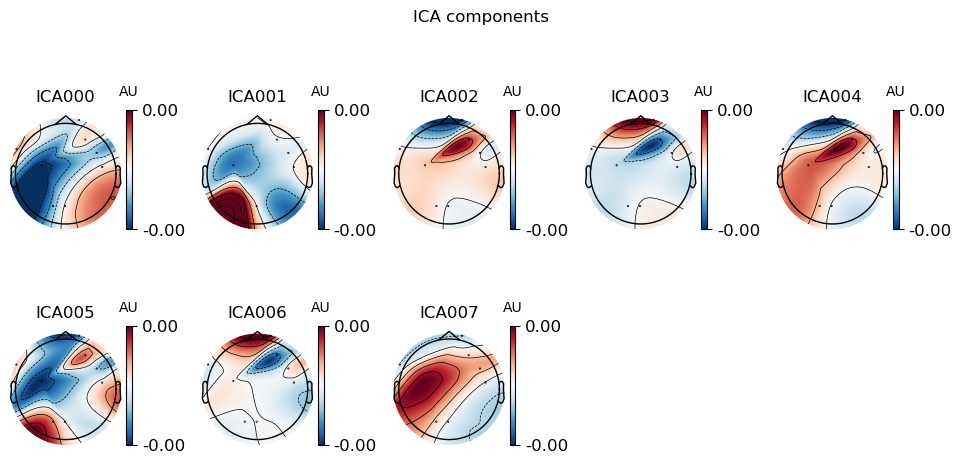

In [16]:
test.init_ICA()
test.plot_sources()

In [ ]:
test.plot_properties([0,7])

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 4 ICA components
    Projecting back using 8 PCA components


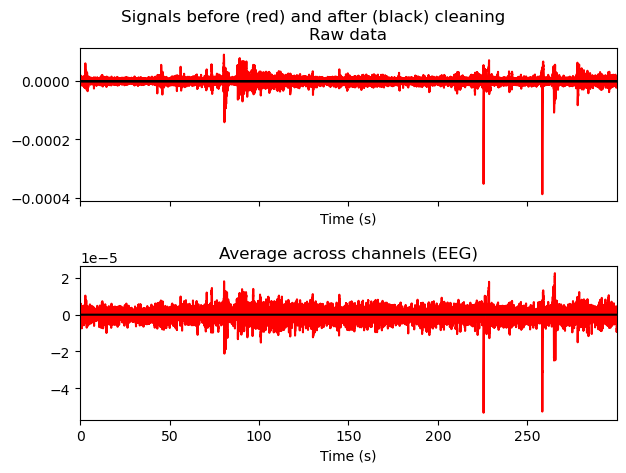

In [18]:
test.test_exclude([2,3,5,7])

In [19]:
test.exclude_ICA([2,3,5,7])
test.plot('raw')
test.plot('reconstructed')

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 4 ICA components
    Projecting back using 8 PCA components


Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
#test.plot('raw', save=True)
#test.plot('filtered', save=True)
#test.plot('ica', save=True)
#test.plot('reconstructed', save=True)

In [ ]:
test.save_data()